###### Aarhus University - Fall 2021 - Renewable Energy Systems (RES) project 

This notebook includes the steps to optimize the capacity and dispatch of generators in the power system of one country.
Make sure that you understand every step in this notebook. For the project of the course Renewable Energy Systems (RES) you need to deliver a report including the sections described at the end of this notebook.

In [66]:
import pypsa

Pandas package is very useful to work with imported data, time series, matrices ...

You can find a 10-minutes guide to pandas in the following link
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

In [67]:
import pandas as pd

We start by creating the network. In this example, the country is modelled as a single node, so the network will only include one bus.

We select the year 2015 and set the hours in that year as snapshots.

We select a country, in this case, Spain (ESP), and add one node (electricity bus) to the network.

In [68]:
network = pypsa.Network()
hours_in_2011 = pd.date_range('2011-01-01T00:00:00','2011-12-31T23:00:00', freq='H') #I changed the date rate from Z
network.set_snapshots(hours_in_2011)

network.add("Bus","electricity bus")

network.snapshots

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2011-12-31 14:00:00', '2011-12-31 15:00:00',
               '2011-12-31 16:00:00', '2011-12-31 17:00:00',
               '2011-12-31 18:00:00', '2011-12-31 19:00:00',
               '2011-12-31 20:00:00', '2011-12-31 21:00:00',
               '2011-12-31 22:00:00', '2011-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

The demand is represented by the historical electricity demand in 2015 with hourly resolution. 

The file with historical hourly electricity demand for every European country is available in the data folder.

The electricity demand time series were obtained from ENTSOE through the very convenient compilation carried out by the Open Power System Data (OPSD). https://data.open-power-system-data.org/time_series/

In [69]:
# load electricity demand data
df_elec = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
print(df_elec['demand_mwh'].head())

Column 1
2011-01-01 00:00:00    47128.8
2011-01-01 01:00:00    52522.3
2011-01-01 02:00:00    52212.0
2011-01-01 03:00:00    50350.0
2011-01-01 04:00:00    48459.0
Name: demand_mwh, dtype: float64


In [70]:
# add load to the bus
network.add("Load",
            "load", 
            bus="electricity bus", 
            p_set=df_elec['demand_mwh'])

Print the load time series to check that it has been properly added (you should see numbers and not 'NaN')

In [71]:
network.loads_t.p_set

,load
snapshot,
2011-01-01 00:00:00,47128.8
2011-01-01 01:00:00,52522.3
2011-01-01 02:00:00,52212.0
2011-01-01 03:00:00,50350.0
2011-01-01 04:00:00,48459.0
...,...
2011-12-31 19:00:00,31488.7
2011-12-31 20:00:00,31279.2
2011-12-31 21:00:00,30967.0


In the optimization, we will minimize the annualized system costs.

We will need to annualize the cost of every generator, we build a function to do it.

In [72]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


We include solar PV and onshore wind generators. 

The capacity factors representing the availability of those generators for every European country can be downloaded from the following repositories (select 'optimal' for PV and onshore for wind). 

https://zenodo.org/record/3253876#.XSiVOEdS8l0

https://zenodo.org/record/2613651#.XSiVOkdS8l0

We include also Open Cycle Gas Turbine (OCGT) generators

The cost assumed for the generators are the same as in the paper https://doi.org/10.1016/j.enconman.2019.111977 (open version:  https://arxiv.org/pdf/1906.06936.pdf)

In [73]:
# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

# add onshore wind generator
df_onshorewind = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind = df_onshorewind['onwind'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(30,0.07)*910000*(1+0.033) # in €/MW #Where are these numbers coming from?
#More specifically, where does the 0.07 and the 1000 multiplying the 910000 come from?
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind) #Does this add 

# add solar PV generator
df_solar = pd.read_csv('data_extra/CaliforniaTimeSeries.csv', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar['solar'][[hour.strftime("%Y-%m-%dT%H:%M:%S") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*425000*(1+0.03) # in €/MW
#capital_cost_solar = 0
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

# add OCGT (Open Cycle Gas Turbine) generator
capital_cost_OCGT = annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)

Print the generator Capacity factor time series to check that it has been properly added (you should see numbers and not 'NaN')

In [74]:
network.generators_t.p_max_pu

,onshorewind,solar
snapshot,,
2011-01-01 00:00:00,0.135,0.247
2011-01-01 01:00:00,0.150,0.000
2011-01-01 02:00:00,0.164,0.000
2011-01-01 03:00:00,0.171,0.000
2011-01-01 04:00:00,0.175,0.000
...,...,...
2011-12-31 19:00:00,0.031,0.555
2011-12-31 20:00:00,0.030,0.623
2011-12-31 21:00:00,0.031,0.636


We solve the linear optimal power flow (lopf) using Gurobi as solver.

In this case, we are optimising the installed capacity and dispatch of every generator to minimize the total system cost.

In [75]:
network.lopf(network.snapshots, 
             pyomo=False,
             solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.98s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-jti8j1ii.lp
Reading time = 0.13 seconds
obj: 61320 rows, 26284 columns, 100738 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61320 rows, 26284 columns and 100738 nonzeros
Model fingerprint: 0xd466db16
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 6e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26276 rows, 17519 columns, 56930 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 3.941e+04
 Factor NZ  : 1.270e+05 (roughly 20 MBytes of memory)
 Factor Ops : 6.612e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 1.63e+10


('ok', 'optimal')

The message "Optimization successful" indicates that the optimizer has found an optimal solution. 

The total cost can be read from the network objetive.

In [76]:
#print(network.objective/1000000) #in 10^6 €
print(network.objective/network.loads_t.p.sum()) # €/MWh

load    53.063703
dtype: float64


The optimal capacity for every generator can be shown.

In [77]:
network.generators.p_nom_opt # in MW

onshorewind    13984.196452
solar          70740.125228
OCGT           54495.769997
Name: p_nom_opt, dtype: float64

We can plot now the dispatch of every generator during the first week of the year and the electricity demand.
We import the matplotlib package which is very useful to plot results.

We can also plot the electricity mix.

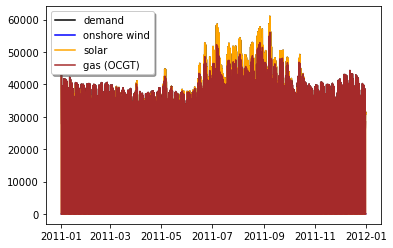

In [65]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:8760], color='black', label='demand')#these are the first 96 hours of data
plt.plot(network.generators_t.p['onshorewind'][0:8760], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:8760], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:8760], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')#at one point, demand perfectly matches onshore wind. However, this is not all the wind that is being produced, right?
plt.savefig('Images/California/TotalCaliforniaZeroCost.png')

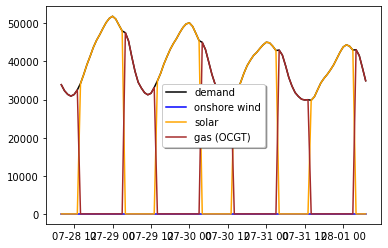

In [52]:
plt.plot(network.loads_t.p['load'][5000:5096], color='black', label='demand')#these are some middle 96 hours of data
plt.plot(network.generators_t.p['onshorewind'][5000:5096], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][5000:5096], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][5000:5096], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.savefig('Images/California/CaliforniaZeroCostJuly.png')

Text(0.5, 1.07, 'Electricity mix')

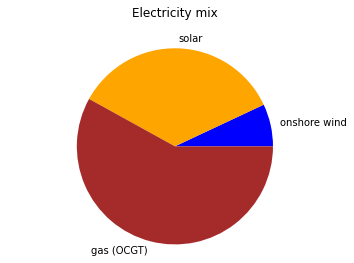

In [15]:
labels = ['onshore wind', 
          'solar', 
          'gas (OCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

We can add a global CO2 constraint and solve again.

In [16]:
co2_limit=400000 #tonCO2 #global as in system global
network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_limit)

In [17]:
network.lopf(network.snapshots, 
             pyomo=False,
             solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.97s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /var/folders/x3/vnc5_2m96vsfhyjnwg076wzr0000gn/T/pypsa-problem-rqxmpsur.lp
Reading time = 0.13 seconds
obj: 61321 rows, 26284 columns, 109498 nonzeros
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61321 rows, 26284 columns and 109498 nonzeros
Model fingerprint: 0x47613cda
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+04, 4e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 35044 rows and 8765 columns
Presolve time: 0.07s
Presolved: 26277 rows, 17519 columns, 65690 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 5.693e+04
 Factor NZ  : 1.534e+05 (roughly 20 MBytes of memory)
 Factor Ops : 9.446e+05 (less than 1 second per iteration)
 Threads    : 1

                 

INFO:pypsa.linopf:Optimization successful. Objective value: 7.02e+10


('ok', 'optimal')

In [18]:
network.generators.p_nom_opt #in MW

onshorewind    860949.403107
solar           93333.623213
OCGT            27060.407163
Name: p_nom_opt, dtype: float64

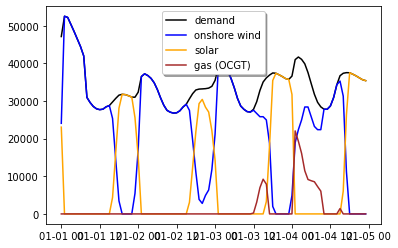

In [19]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')#why does the demand curve not go all the way? why is the gas curve so weird?
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

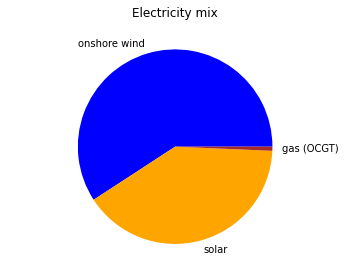

In [20]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors = ['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## PROJECT INSTRUCTIONS

Based on the previous example, you are asked to carry out the following tasks:

A. Choose a different country/region and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution from different technologies. 

B. Investigate how sensitive is the optimum capacity mix to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer the emissions allowance to that historical data. 

C. Investigate how sensitive are your results to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years. 

D. Add some storage technology/ies and investigate how they behave and what is their impact on the optimal system configuration. 

E. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.) 

F. Select on target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your result. 

G. Connect your country with, at least, two neighbour countries. You can assume that the capacities in the neighbours are fixed or cooptimize the whole system. You can also include fixed interconnection capacities or cooptimize them with the generators capacities. Discuss your results.

H. Connect the electricity sector with another sector such as heating or transport, and cooptimize the two sectors. Discuss your results.

I. Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g. 

[-] What are the consequences if Denmark decides not to install more onshore wind? 

[-] Would it be more expensive if France decides to close its nuclear power plants? 

[-] What will be the main impacts of the Viking link?

Write a short report (maximum 10 pages) including your main findings.

In [21]:
###What is a duration curve?





_TIP 1: You can add a link with the following code_

The efficiency will be 1 if you are connecting two countries and different from one if, for example, you are connecting the electricity bus to the heating bus using a heat pump.
Setting p_min_pu=-1 makes the link reversible.


In [22]:
network.add("Link",
             'country a - country b',
             bus0="electricity bus country a",
             bus1="electricity bus country b",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             length=600, # length (in km) between country a and country b
             capital_cost=400*600) # capital cost * length 


_TIP 2: You can check the KKT multiplier associated with the constraint with the following code_


In [23]:
print(network.global_constraints.constant) #CO2 limit (constant in the constraint)

print(network.global_constraints.mu) #CO2 price (Lagrance multiplier in the constraint)

co2_limit    400000.0
Name: constant, dtype: float64
co2_limit    73378.663127
Name: mu, dtype: float64


TIP 3: You can add a H2 store connected to the electricity bus via an electrolyzer and a fuel cell with the following code. 

In [24]:
#Create a new carrier
network.add("Carrier",
      "H2")

#Create a new bus
network.add("Bus",
      "H2",
      carrier = "H2")

#Connect the store to the bus
network.add("Store",
      "H2 Tank",
      bus = "H2",
      e_nom_extendable = True,
      e_cyclic = True,
      capital_cost = annuity(25, 0.07)*57000*(1+0.011))

#Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
#with 80% efficiency
network.add("Link",
      "H2 Electrolysis", 
      bus0 = "electricity bus",
      bus1 = "H2",     
      p_nom_extendable = True,
      efficiency = 0.8,
      capital_cost = annuity(25, 0.07)*600000*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
      "H2 Fuel Cell", 
      bus0 = "H2",
      bus1 = "electricity bus",     
      p_nom_extendable = True,
      efficiency = 0.58,
      capital_cost = annuity(10, 0.07)*1300000*(1+0.05)) 
